In [37]:
import os
import math
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from scipy import signal, stats
from scipy.spatial import distance
from numpy import linalg as LA
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn import metrics
from sklearn.cluster import kmeans_plusplus
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

In [4]:
def uncertainity_mean(X_train1,pred,means,covariances,weights,km,numberofdimens):
  X_train1["pred"]=pred
  meanss=means
  weiths=weights
  variances=[]
  covariancematrix=covariances
  for i in covariancematrix: #The diagonal of cov is the variance of each gmm
    diag=np.diag(i)
    variances.append(diag)
  variances=np.array(variances)
  countiterations=0
  unc=[]
  un=[]

  sep=[]
  for g in range(0,len(meanss)):  ##Frechet distance
    for t in range(0,len(meanss)):
      if (t==g):
        continue
      else:
        sep.append(frechetDistance(meanss[t],meanss[g],covariancematrix[t],covariancematrix[g]))
  separation=np.array(sep)
  Dmin=np.array(separation).min()
  Dmax=np.array(separation).max()
  Sep=(Dmax/Dmin)*(1/separation.sum())

  for i in range(0,len(meanss)):  #Uncertainty  ##i run each cluster
    cweight=weiths[i]
    cmean=meanss[i]
    cvar=variances[i]
    lim_inf=cmean-(km*cvar)
    lim_sup=cmean+(km*cvar)
    unc=[]
    o=X_train1[X_train1["pred"]==i].iloc[:,:numberofdimens].copy()

    for j in range(len(o)): # j run each data
      DM=distance.mahalanobis(np.array(o.iloc[j]), cmean, np.linalg.inv(covariancematrix[i]))
      varbool=(DM>=km)
      varunc=[]
      #print("varbool",varbool)
      if (varbool):
        varunc.append(2*km*DM)
      else:
        vs=((DM**2)+(km*DM)+(km**2)/2)
        varunc.append(vs)
    un.append(np.array(varunc))
  return np.sum(un)/Sep

In [5]:

def merguncertain (xtrain,y,Means,covariances,weights,numberofdimens):
  X_train11=xtrain
  X_train11["pred"]=y
  UNIndex=[]
  len(Means)
  Pairwise=np.ones((len(Means), len(Means)))
  labels=[]
  for i in range(len(Means)):
    labels.append(i)
    for j in range(len(Means)):
        if (i==j):
          continue
        Pairwise[j,i]=(frechetDistance(Means[i],Means[j],covariances[i],covariances[j]))

  while len(Pairwise) > 2 :
      UNIndex.append(uncertainity_mean(X_train11.iloc[:,:numberofdimens],X_train11["pred"],Means,covariances,weights,1,numberofdimens))

      Similar_clusters=np.unravel_index(Pairwise.argmin(),Pairwise.shape)
      Similar_clusters_labels=( labels[Similar_clusters[0]],labels[Similar_clusters[1]])

      #update Mean
      data_size_1=len(X_train11[X_train11["pred"]==Similar_clusters_labels[0]])
      data_size_2=len(X_train11[X_train11["pred"]==Similar_clusters_labels[1]])
      mean_1=Means[Similar_clusters[0]]
      mean_2=Means[Similar_clusters[1]]
      new_mean = (data_size_1* mean_1 + data_size_2*mean_2)/(data_size_1 + data_size_2)
      Means[Similar_clusters[0]]=new_mean

      #Update labels
      X_train11["pred"]=X_train11["pred"].replace(Similar_clusters_labels[1], Similar_clusters_labels[0])
      #print(X_train11["pred"].unique())
      NewCovariance=X_train11[X_train11["pred"]==Similar_clusters_labels[0]].iloc[:,:numberofdimens].cov()
      covariances[Similar_clusters[0]]=NewCovariance
      weights[Similar_clusters[0]]=weights[Similar_clusters[0]]+weights[Similar_clusters[1]]

      updpairwisecolum=[]
      for j in range(0,len(Means)):
          updpairwisecolum.append((frechetDistance(Means[Similar_clusters[0]],Means[j],covariances[Similar_clusters[0]],covariances[j])))
      #print(updpairwisecolum)
      Pairwise[:,Similar_clusters[0]]=updpairwisecolum
      Pairwise[Similar_clusters[0],:]=updpairwisecolum

      Means= np.delete(Means, (Similar_clusters[1]), axis=0)
      weights= np.delete(weights, (Similar_clusters[1]), axis=0)
      covariances=np.delete(covariances, (Similar_clusters[1]), axis=0)
      labels.remove(Similar_clusters_labels[1])
      Pairwise= np.delete(Pairwise, (Similar_clusters[1]), axis=0)
      Pairwise= np.delete(Pairwise, (Similar_clusters[1]), axis=1)
      np.fill_diagonal(Pairwise, 1)
  return UNIndex

In [6]:
def frechetDistance(u1,u2,E1,E2):
  return (LA.norm(np.absolute(u1-u2)**2))+np.trace(E1+E2-(2*(E1*E2)**(0.5)))

#Iris Dataset


In [7]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()
data1 = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

In [8]:
data1

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


## Approach 1: Calculating performance in base of index UF


In [38]:
Index=[]
liminfierior=2
limsuperior=20
for i in range(2,20):
  Y = data1["target"]
  X = data1.drop(columns = "target")

  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y)$

  X_train111=X.copy()
  GM = GaussianMixture(n_components=i, covariance_type="full",random_state=1).fit(X_train111)
  X_train111["pred"]=GM.predict(X_train111)
  Means=GM.means_
  covariances=GM.covariances_
  weights=GM.weights_
  numberofdimens=X_train111.shape[1]-1
  y=X_train111["pred"]
  Index.append(uncertainity_mean(X_train111.iloc[:,:numberofdimens],X_train111["pred"],Means,covariances,weights,1,numberofdimens))


<Axes: xlabel='ind'>

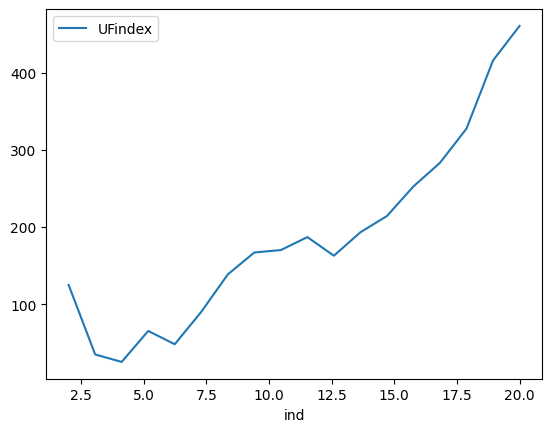

In [39]:
change=pd.DataFrame(Index,columns=["UFindex"])
change["ind"]=np.linspace(2,len(change)+2,len(change))

change.plot("ind",["UFindex"])

In [18]:
change["UFindex"].argmin()

2

## Approach 2: Meging methodology


<Axes: xlabel='ind'>

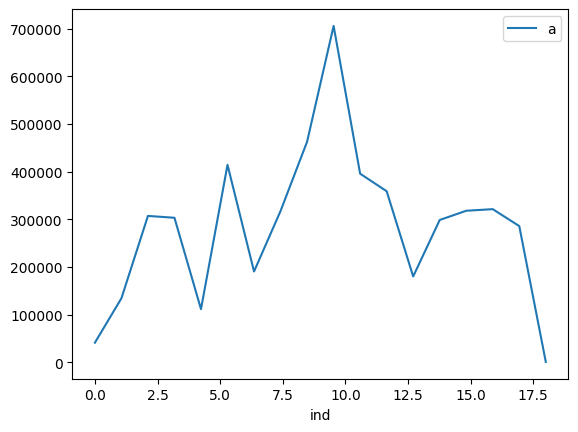

In [40]:
from sklearn.model_selection import train_test_split

Y = data1["target"]
X = data1.drop(columns = "target")

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y)$

X_train111=X.copy()
GM = GaussianMixture(n_components=20, covariance_type="full", random_state= 5).fit(X_train111)
X_train111["pred"]=GM.predict(X_train111)
Means=GM.means_
covariances=GM.covariances_
weights=GM.weights_
y=X_train111["pred"]
index=merguncertain (X,y,Means,covariances,weights,X.shape[1])

index.reverse()
change=pd.DataFrame(index,columns=["a"])
change["ind"]=np.linspace(0,len(change),len(change))

change.plot("ind",["a"])


In [35]:

change=change.iloc[:-1,:]

In [36]:

recomended=change["a"].argmin()+2
GMM_test= GaussianMixture(n_components=recomended, covariance_type="full",random_state=0).fit(X)
predy=GMM_test.predict(X)
recomended

2